# Photometry

This is the sixth in a series of notebooks related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the previous lesson we downloaded photometry data from Pan-STARRS, which is available from the same server we've been using to get Gaia data. 

The next step in the analysis is to select candidate stars based on the photometry data.  
The following figure from the paper is a color-magnitude diagram showing the stars we previously selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

In red is a theoretical isochrone, showing where we expect the stars in GD-1 to fall based on the metallicity and age of their original globular cluster. 

By selecting stars in the shaded area, we can further distinguish the main sequence of GD-1 from mostly younger background stars.

## Outline

Here are the steps in this notebook:

1. We'll reload the data from the previous notebook and make a color-magnitude diagram.

2. We'll use an isochrone computed by MIST to specify a polygonal region in the color-magnitude diagram and select the stars inside it.

3. Then we'll merge the photometry data with the list of candidate stars, storing the result in a Pandas `DataFrame`.

After completing this lesson, you should be able to

* Use Matplotlib to specify a `Polygon` and determine which points fall inside it.

* Use Pandas to merge data from multiple `DataFrames`, much like a database `JOIN` operation.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala wget

## Reload the data

The following cell downloads the photometry data we created in the previous notebook.

In [2]:
import os
from wget import download

filename = 'gd1_photo.fits'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

Now we can read the data back into an Astropy `Table`.

In [3]:
from astropy.table import Table

photo_table = Table.read(filename)

## Plotting photometry data

Now that we have photometry data from Pan-STARRS, we can replicate the [color-magnitude diagram](https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram) from the original paper:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

The y-axis shows the apparent magnitude of each source with the [g filter](https://en.wikipedia.org/wiki/Photometric_system).

The x-axis shows the difference in apparent magnitude between the g and i filters, which indicates color.

Stars with lower values of (g-i) are brighter in g-band than in i-band, compared to other stars, which means they are bluer.

Stars in the lower-left quadrant of this diagram are less bright than the others, and have lower metallicity, which means they are [likely to be older](http://spiff.rit.edu/classes/ladder/lectures/ordinary_stars/ordinary.html).

Since we expect the stars in GD-1 to be older than the background stars, the stars in the lower-left are more likely to be in GD-1.

The following function takes a table containing photometry data and draws a color-magnitude diagram.
The input can be an Astropy `Table` or Pandas `DataFrame`, as long as it has columns named `g_mean_psf_mag` and `i_mean_psf_mag`.



In [4]:
import matplotlib.pyplot as plt

def plot_cmd(table):
    """Plot a color magnitude diagram.
    
    table: Table or DataFrame with photometry data
    """
    y = table['g_mean_psf_mag']
    x = table['g_mean_psf_mag'] - table['i_mean_psf_mag']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlim([0, 1.5])
    plt.ylim([14, 22])
    plt.gca().invert_yaxis()

    plt.ylabel('$Magnitude (g)$')
    plt.xlabel('$Color (g-i)$')

`plot_cmd` uses a new function, `invert_yaxis`, to invert the `y` axis, which is conventional when plotting magnitudes, since lower magnitude indicates higher brightness.

`invert_yaxis` is a little different from the other functions we've used.  You can't call it like this:

```
plt.invert_yaxis()          # doesn't work
```

You have to call it like this:

```
plt.gca().invert_yaxis()          # works
```

`gca` stands for "get current axis".  It returns an object that represents the axes of the current figure, and that object provides `invert_yaxis`.

**In case anyone asks:** The most likely reason for this inconsistency in the interface is that `invert_yaxis` is a lesser-used function, so it's not made available at the top level of the interface.

Here's what the results look like.

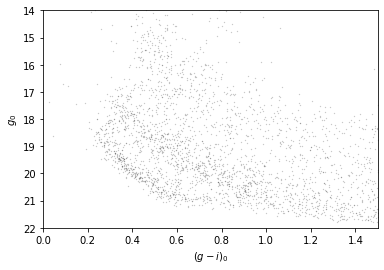

In [5]:
plot_cmd(photo_table)

Our figure does not look exactly like the one in the paper because we are working with a smaller region of the sky, so we don't have as many stars.  But we can see an overdense region in the lower left that contains stars with the photometry we expect for GD-1.

In the next section we'll use an isochrone to specify a polygon that contains this overdense regioin.

## Isochrone

Based on our best estimates for the ages of the stars in GD-1 and their metallicity, we can compute a [stellar isochrone](https://en.wikipedia.org/wiki/Stellar_isochrone) that predicts the relationship between their magnitude and color.

In fact, we can use [MESA Isochrones & Stellar Tracks](http://waps.cfa.harvard.edu/MIST/) (MIST) to compute it for us.

Using the [MIST Version 1.2 web interface](http://waps.cfa.harvard.edu/MIST/interp_isos.html), we computed an isochrone with the following parameters:
    
* Rotation initial v/v_crit = 0.4

* Single age, linear scale = 12e9

* Composition [Fe/H] = -1.35

* Synthetic Photometry, PanStarrs

* Extinction av = 0

The following cell downloads the results:

In [6]:
import os
from wget import download

filename = 'MIST_iso_5fd2532653c27.iso.cmd'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

To read this file we'll download a Python module [from this repository](https://github.com/jieunchoi/MIST_codes).

In [7]:
import os
from wget import download

filename = 'read_mist_models.py'
filepath = 'https://github.com/jieunchoi/MIST_codes/raw/master/scripts/'

if not os.path.exists(filename):
    print(download(filepath+filename))

Now we can read the file:

In [8]:
import read_mist_models

filename = 'MIST_iso_5fd2532653c27.iso.cmd'
iso = read_mist_models.ISOCMD(filename)

Reading in: MIST_iso_5fd2532653c27.iso.cmd


The result is an `ISOCMD` object.

In [9]:
type(iso)

read_mist_models.ISOCMD

It contains a list of arrays, one for each isochrone.

In [10]:
type(iso.isocmds)

list

We only got one isochrone.

In [11]:
len(iso.isocmds)

1

So we can select it like this:

In [12]:
iso_array = iso.isocmds[0]

It's a NumPy array:

In [13]:
type(iso_array)

numpy.ndarray

But it's an unusual NumPy array, because it contains names for the columns.

In [14]:
iso_array.dtype

dtype([('EEP', '<i4'), ('isochrone_age_yr', '<f8'), ('initial_mass', '<f8'), ('star_mass', '<f8'), ('log_Teff', '<f8'), ('log_g', '<f8'), ('log_L', '<f8'), ('[Fe/H]_init', '<f8'), ('[Fe/H]', '<f8'), ('PS_g', '<f8'), ('PS_r', '<f8'), ('PS_i', '<f8'), ('PS_z', '<f8'), ('PS_y', '<f8'), ('PS_w', '<f8'), ('PS_open', '<f8'), ('phase', '<f8')])

Which means we can select columns using the bracket operator:

In [15]:
iso_array['phase']

array([0., 0., 0., ..., 6., 6., 6.])

We can use `phase` to select the part of the isochrone for stars in the main sequence and red giant phases.

In [16]:
phase_mask = (iso_array['phase'] >= 0) & (iso_array['phase'] < 3)
phase_mask.sum()

354

In [17]:
main_sequence = iso_array[phase_mask]
len(main_sequence)

354

The other two columns we'll use are `PS_g` and `PS_i`, which contain simulated photometry data for stars with the given age and metallicity, based on a model of the Pan-STARRS sensors.

We'll use these columns to superimpose the isochrone on the color-magnitude diagram, but first we have to use a [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) to scale the isochrone based on the estimated distance of GD-1.

We can use the `Distance` object from Astropy to compute the distance modulus.

In [18]:
import astropy.coordinates as coord
import astropy.units as u

distance = 7.8 * u.kpc
distmod = coord.Distance(distance).distmod.value
distmod

14.4604730134524

Now we can compute the scaled magnitude and color of the isochrone.

In [19]:
mag_g = main_sequence['PS_g'] + distmod
color_g_i = main_sequence['PS_g'] - main_sequence['PS_i']

Now we can plot it on the color-magnitude diagram like this.

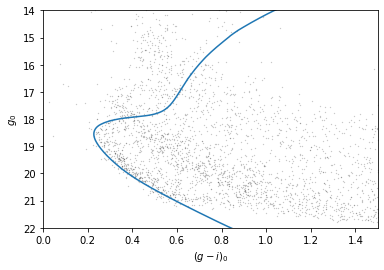

In [20]:
plot_cmd(photo_table)
plt.plot(color_g_i, mag_g);

The theoretical isochrone passes through the overdense region where we expect to find stars in GD-1.

Let's save this result so we can reload it later without repeating the steps in this section.

So we can save the data in an HDF5 file, we'll put it in a Pandas `DataFrame` first:

In [21]:
import pandas as pd

iso_df = pd.DataFrame()
iso_df['mag_g'] = mag_g
iso_df['color_g_i'] = color_g_i

iso_df.head()

,mag_g,color_g_i
0,28.294743,2.195021
1,28.189718,2.166076
2,28.051761,2.129312
3,27.916194,2.093721
4,27.780024,2.058585


And then save it.

In [22]:
filename = 'gd1_isochrone.hdf5'

iso_df.to_hdf(filename, 'iso_df')

## Making a polygon

The following cell downloads the isochrone we made in the previous section, if necessary.

In [23]:
import os
from wget import download

filename = 'gd1_isochrone.hdf5'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

Now we can read it back in.

In [24]:
iso_df = pd.read_hdf(filename, 'iso_df')
iso_df.head()

,mag_g,color_g_i
0,28.294743,2.195021
1,28.189718,2.166076
2,28.051761,2.129312
3,27.916194,2.093721
4,27.780024,2.058585


Here's what the isochrone looks like on the color-magnitude diagram.

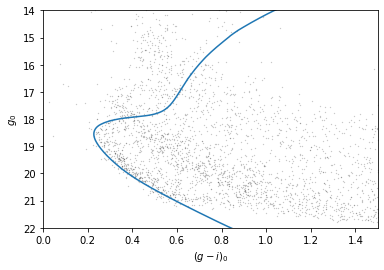

In [25]:
plot_cmd(photo_table)
plt.plot(iso_df['color_g_i'], iso_df['mag_g']);

In the bottom half of the figure, the isochrone passes through the overdense region where the stars are likely to belong to GD-1.

In the top half, the isochrone passes through other regions where the stars have higher magnitude and metallicity than we expect for stars in GD-1.

So we'll select the part of the isochrone that lies in the overdense region.

`g_mask` is a Boolean Series that is `True` where `g` is between 18.0 and 21.5.

In [26]:
g = iso_df['mag_g']

g_mask = (g > 18.0) & (g < 21.5)
g_mask.sum()

117

We can use it to select the corresponding rows in `iso_df`:

In [27]:
iso_masked = iso_df[g_mask]
iso_masked.head()

,mag_g,color_g_i
94,21.411746,0.692171
95,21.322466,0.670238
96,21.233380,0.648449
97,21.144427,0.626924
98,21.054549,0.605461


Now, to select the stars in the overdense region, we have to define a polygon that includes stars near the isochrone.

The original paper uses the following formulas to define the left and right boundaries. 

In [28]:
g = iso_masked['mag_g']
left_color = iso_masked['color_g_i'] - 0.4 * (g/28)**5
right_color = iso_masked['color_g_i'] + 0.8 * (g/28)**5

The intention seems to be to define a polygon that gets wider as `g` increases.

But we can do about as well with a simpler formula:

In [29]:
g = iso_masked['mag_g']
left_color = iso_masked['color_g_i'] - 0.06
right_color = iso_masked['color_g_i'] + 0.12

Here's what these boundaries look like:

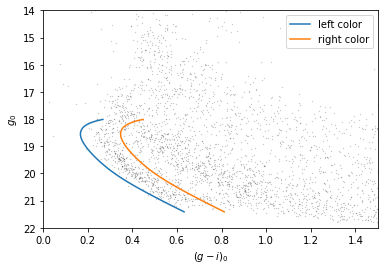

In [30]:
plot_cmd(photo_table)

plt.plot(left_color, g, label='left color')
plt.plot(right_color, g, label='right color')

plt.legend();

## Which points are in the polygon?

Matplotlib provides a `Polygon` object that we can use to check which points fall in the polygon we just constructed.

To make a `Polygon`, we need to assemble `g`, `left_color`, and `right_color` into a loop, so the points in `left_color` are connected to the points of `right_color` in reverse order.

We'll use the following function, which takes two arrays and joins them front-to-back:

In [54]:
import numpy as np

def front_to_back(first, second):
    """Join two arrays front to back."""
    return np.append(first, second[::-1])

`front_to_back` uses a "slice index" to reverse the elements of `second`.

As explained in the [NumPy documentation](https://numpy.org/doc/stable/reference/arrays.indexing.html), a slice index has three parts separated by colons:

* `start`: The index of the element where the slice starts.

* `stop`: The index of the element where the slice ends.

* `step`: The step size between elements.

In this example, `start` and `stop` are omitted, which means all elements are selected.

And `step` is `-1`, which means the elements are in reverse order.

We can use `front_to_back` to make a loop that includes the elements of `left_color` and `right_color`:

In [55]:
color_loop = front_to_back(left_color, right_color)
color_loop.shape

(234,)

And a corresponding loop with the elements of `g` in forward and reverse order.

In [56]:
mag_loop = front_to_back(g, g)
mag_loop.shape

(234,)

Here's what the loop looks like.

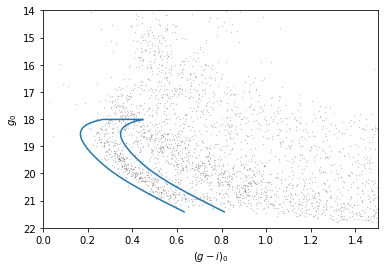

In [57]:
plot_cmd(photo_table)
plt.plot(color_loop, mag_loop);

To make a `Polygon`, it will be convenient to put `color_loop` and `mag_loop` into a `DataFrame`:

In [58]:
loop_df = pd.DataFrame()
loop_df['color_loop'] = color_loop
loop_df['mag_loop'] = mag_loop

Now we can pass `loop_df` to `Polygon`:

In [62]:
from matplotlib.patches import Polygon

polygon = Polygon(loop_df)
polygon

The result is a `Polygon` object , which provides `contains_points`, which figures out which points are inside the polygon.

To test it, we'll create a list with two points, one inside the polygon and one outside.

In [63]:
points = [(0.4, 20), 
          (0.4, 16)]

Now we can make sure `contains_points` does what we expect.

In [64]:
inside = polygon.contains_points(points)
inside

array([ True, False])

The result is an array of Boolean values.

We are almost ready to select stars whose photometry data falls in this polygon.  But first we need to do some data cleaning.

## Save the polygon

[Reproducibile research](https://en.wikipedia.org/wiki/Reproducibility#Reproducible_research) is "the idea that ... the full computational environment used to produce the results in the paper such as the code, data, etc. can be used to reproduce the results and create new work based on the research."

This Jupyter notebook is an example of reproducible research because it contains all of the code needed to reproduce the results, including the database queries that download the data and and analysis.

In this lesson we used an isochrone to derive a polygon, which we used to select stars based on photometry. 
So it is important to record the polygon as part of the data analysis pipeline.

Here's how we can save it in an HDF file.

In [80]:
filename = 'gd1_polygon.hdf5'
loop_df.to_hdf(filename, 'loop_df')

## Reloading the data

Now we need to combine the photometry data with the list of candidate stars we identified in a previous notebook.  The following cell downloads it:



In [66]:
import os
from wget import download

filename = 'gd1_candidates.hdf5'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

In [67]:
import pandas as pd

candidate_df = pd.read_hdf(filename, 'candidate_df')

`candidate_df` is the Pandas DataFrame that contains the results from Lesson 4, which selects stars likely to be in GD-1 based on proper motion.  It also includes position and proper motion transformed to the ICRS frame.

## Merging photometry data

Before we select stars based on photometry data, we have to solve two problems:

1. We only have Pan-STARRS data for some stars in `candidate_df`.

2. Even for the stars where we have Pan-STARRS data in `photo_table`, some photometry data is missing.

We will solve these problems in two step:

1. We'll merge the data from `candidate_df` and `photo_table` into a single Pandas `DataFrame`.

2. We'll use Pandas functions to deal with missing data.

`candidate_df` is already a `DataFrame`, but `results` is an Astropy `Table`.  Let's convert it to Pandas:

In [68]:
photo_df = photo_table.to_pandas()

for colname in photo_df.columns:
    print(colname)

source_id
g_mean_psf_mag
i_mean_psf_mag


Now we want to combine `candidate_df` and `photo_df` into a single table, using `source_id` to match up the rows.

You might recognize this task; it's the same as the JOIN operation in ADQL/SQL.

Pandas provides a function called `merge` that does what we want.  Here's how we use it.

In [69]:
merged = pd.merge(candidate_df, 
                  photo_df, 
                  on='source_id')
merged.head()

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,phi1,phi2,pm_phi1,pm_phi2,g_mean_psf_mag,i_mean_psf_mag
0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,NaN,-59.247330,-2.016078,-7.527126,1.748779,17.8978,17.517401
1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,NaN,-59.133391,-2.306901,-7.560608,-0.741800,19.2873,17.678101
2,635535454774983040,137.837752,18.864007,-4.335041,-14.492309,0.314514,NaN,-59.785300,-1.594569,-9.357536,-1.218492,16.9238,16.478100
3,635497276810313600,138.044516,19.009471,-7.172931,-12.291499,0.425404,NaN,-59.557744,-1.682147,-9.000831,2.334407,19.9242,18.334000
4,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,0.583382,NaN,-58.938113,-3.024192,-8.062762,-1.869082,16.1516,14.666300


The first argument is the "left" table, the second argument is the "right" table, and the keyword argument `on='source_id'` specifies a column to use to match up the rows.

The result is a `DataFrame` that contains the same number of rows as `photo_df`. 

In [70]:
len(candidate_df), len(photo_df), len(merged)

(7346, 3724, 3724)

And it contains all columns from both tables.

In [71]:
for colname in merged.columns:
    print(colname)

source_id
ra
dec
pmra
pmdec
parallax
radial_velocity
phi1
phi2
pm_phi1
pm_phi2
g_mean_psf_mag
i_mean_psf_mag


**Detail** You might notice that Pandas also provides a function called `join`; it does almost the same thing, but the interface is slightly different.  We think `merge` is a little easier to use, so that's what we chose.  It's also more consistent with JOIN in SQL, so if you learn how to use `pd.merge`, you are also learning how to use SQL JOIN.

Also, someone might ask why we have to use Pandas to do this join; why didn't we do it in ADQL.  The answer is that we could have done that, but since we already have the data we need, we should probably do the computation locally rather than make another round trip to the Gaia server.

## Selecting based on photometry

Now let's see how many of these points are inside the polygon we chose.

We'll put color and magnitude data from `merged` into a new `DataFrame`:

In [72]:
points = pd.DataFrame()

points['color'] = merged['g_mean_psf_mag'] - merged['i_mean_psf_mag']
points['mag'] = merged['g_mean_psf_mag']

points.head()

,color,mag
0,0.3804,17.8978
1,1.6092,19.2873
2,0.4457,16.9238
3,1.5902,19.9242
4,1.4853,16.1516


Which we can pass to `contains_points`:

In [73]:
inside = polygon.contains_points(points)
inside

array([False, False, False, ..., False, False, False])

The result is a Boolean array.  We can use `sum` to see how many stars fall in the polygon.

In [74]:
inside.sum()

454

Now we can use `inside` as a mask to select stars that fall inside the polygon.

In [75]:
selected2 = merged[inside]
points2 = points[inside]

Let's make a color-magnitude plot one more time, highlighting the selected stars with green markers.

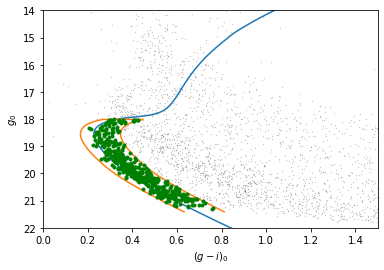

In [76]:
plot_cmd(photo_table)
plt.plot(color_g_i, mag_g)
plt.plot(color_loop, mag_loop)

plt.plot(points2['color'], points2['mag'], 'g.');

It looks like the selected stars are, in fact, inside the polygon, which means they have photometry data consistent with GD-1.

Finally, we can plot the coordinates of the selected stars:

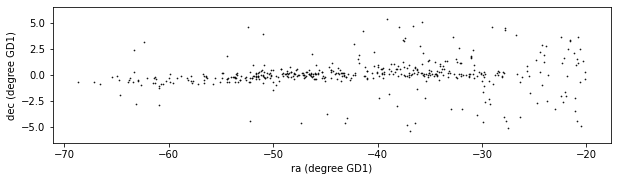

In [77]:
plt.figure(figsize=(10,2.5))

x = selected2['phi1']
y = selected2['phi2']

plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)')

plt.axis('equal');

This example includes two new Matplotlib commands:

* `figure` creates the figure.  In previous examples, we didn't have to use this function; the figure was created automatically.  But when we call it explicitly, we can provide arguments like `figsize`, which sets the size of the figure.

* `axis` with the parameter `equal` sets up the axes so a unit is the same size along the `x` and `y` axes.

In an example like this, where `x` and `y` represent coordinates in space, equal axes ensures that the distance between points is represented accurately.   

## Write the data

Finally, let's write the merged DataFrame to a file.

In [78]:
filename = 'gd1_merged.hdf5'

merged.to_hdf(filename, 'merged')
selected2.to_hdf(filename, 'selected2')

In [79]:
!ls -lh gd1_merged.hdf5

-rw-rw-r-- 1 downey downey 1.1M Dec 28 14:34 gd1_merged.hdf5


If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_merged.hdf5
```

## Summary

In this lesson, we worked with three datasets: 

* The list of candidate stars from Gaia,

* The photometry data from Pan-STARRS, and

* An isochrone computed by MIST.

We drew a color-magnitude diagram and used it to identify stars we think are likely to be in GD-1.

We used the isochrone to define a polygon that includes those stars.

Then we used a Pandas `merge` operation to combine Gaia and Pan-STARRS data into a single `DataFrame`.

Plotting the results, we have a clear picture of GD-1, similar to Figure 1 in the original paper.

## Best practices

* Matplotlib provides operations for working with points, polygons, and other geometric entities, so it's not just for making figures.

* If you want to perform something like a database `JOIN` operation with data that is in a Pandas `DataFrame`, you can use the `join` or `merge` function.  In many cases, `merge` is easier to use because the arguments are more like SQL.

* Use Matplotlib options to control the size and aspect ratio of figures to make them easier to interpret.  In this example, we scaled the axes so the size of a degree is equal along both axes.

* Be sure to record every element of the data analysis pipeline that would be needed to replicate the results.